In [1]:
!pip install transformers
!pip install -q torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 모델 이름
model_name = "ProsusAI/finbert"

# 토크나이저 및 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 파이프라인 생성 (감성 분석용)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [3]:
# Colab에 kaggle.json 업로드
from google.colab import files,drive
drive.mount('/gdrive')
# .kaggle 폴더로 옮기기
%cd '/gdrive/MyDrive/finn-project'
# !ls
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # 권한 설정
# !chmod 600 ~/.kaggle/kaggle.json

# # 필요한 데이터셋 다운로드
# !kaggle datasets download -d journeyyouyeonkim/microsoft-tesla-finance-news-articles2020-2024

# # 압축 해제
# !unzip microsoft-tesla-finance-news-articles2020-2024.zip


Mounted at /gdrive
/gdrive/MyDrive/finn-project


In [4]:
import pandas as pd

# CSV 파일 읽기
news_train_df = pd.read_csv("tsla_news_train.csv")
news_test_df = pd.read_csv("tsla_news_test.csv")

# 앞 5개 행 확인
news_train_df.head()
news_test_df.head()

,date,title,link,source
0,2025-01-01,This Tesla Model 3 Rival In China Is Affordabl...,https://news.google.com/rss/articles/CBMidEFVX...,InsideEVs
1,2025-01-01,"1 person dies, 7 hurt in Tesla truck fire outs...",https://news.google.com/rss/articles/CBMipwFBV...,VOA - Voice of America English News
2,2025-01-01,"Tesla catches fire in Madera County, 2 men tra...",https://news.google.com/rss/articles/CBMirAFBV...,KMPH
3,2025-01-01,Tesla Cybertruck explosion in Las Vegas: What ...,https://news.google.com/rss/articles/CBMihwFBV...,Mashable
4,2025-01-01,One dead after Tesla Cybertruck explodes outsi...,https://news.google.com/rss/articles/CBMijwFBV...,The Guardian


In [5]:
subset_train = news_train_df[['date', 'title']].copy()
subset_test = news_test_df[['date', 'title']].copy()

# 감성 분석 함수 정의
def analyze_sentiment(text):
    result = finbert(text[:512])[0]
    return pd.Series([result['label'], round(result['score'], 4)])

# sentiment와 confidence 컬럼 생성
subset_train[['sentiment', 'confidence']] = subset_train['title'].apply(analyze_sentiment)
subset_test[['sentiment', 'confidence']] = subset_test['title'].apply(analyze_sentiment)

# 텍스트는 제거하고 최종 결과만 남김
news_train_df = subset_train[['date', 'sentiment', 'confidence']]
news_test_df = subset_test[['date', 'sentiment', 'confidence']]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [6]:
news_train_df = news_train_df.sort_values(by='date', ascending=True).reset_index(drop=True)
news_test_df = news_test_df.sort_values(by='date', ascending=True).reset_index(drop=True)

news_train_df.head(5)
news_test_df.head(5)

,date,sentiment,confidence
0,2025-01-01,neutral,0.9032
1,2025-01-01,negative,0.7729
2,2025-01-01,neutral,0.8567
3,2025-01-01,negative,0.8651
4,2025-01-01,positive,0.9340


In [7]:
import pandas as pd

# CSV 파일 읽기
stock_train_df = pd.read_csv("tsla_prices_train.csv")
stock_test_df = pd.read_csv("tsla_prices_test.csv")

# 앞 5개 행 확인
stock_train_df.head()
stock_test_df.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2025-01-02 00:00:00+00:00,379.28,392.7299,373.04,390.10,109710749,379.28,392.7299,373.04,390.10,109710749,0.0,1.0
1,2025-01-03 00:00:00+00:00,410.44,411.8799,379.45,381.48,95423329,410.44,411.8799,379.45,381.48,95423329,0.0,1.0
2,2025-01-06 00:00:00+00:00,411.05,426.4300,401.70,423.20,85516534,411.05,426.4300,401.70,423.20,85516534,0.0,1.0
3,2025-01-07 00:00:00+00:00,394.36,414.3300,390.00,405.83,75699525,394.36,414.3300,390.00,405.83,75699525,0.0,1.0
4,2025-01-08 00:00:00+00:00,394.94,402.4999,387.40,392.95,73038805,394.94,402.4999,387.40,392.95,73038805,0.0,1.0


In [8]:
stock_train_df['date'] = pd.to_datetime(stock_train_df['date']).dt.strftime('%Y-%m-%d')
stock_test_df['date'] = pd.to_datetime(stock_test_df['date']).dt.strftime('%Y-%m-%d')

In [9]:
# 감정 데이터와 주가 데이터 모두 datetime 형식으로 통일
news_train_df['date'] = pd.to_datetime(news_train_df['date'])
news_test_df['date'] = pd.to_datetime(news_test_df['date'])

stock_train_df['date'] = pd.to_datetime(stock_train_df['date'])
stock_test_df['date'] = pd.to_datetime(stock_test_df['date'])

In [10]:
merged_train = pd.merge(
    news_train_df,          # 감정 분석 데이터 (왼쪽 기준)
    stock_train_df,          # 주가 데이터
    how='left',        # 감정 날짜 기준으로 붙이고, 주가 없으면 NaN
    left_on='date',
    right_on='date',
)

merged_test = pd.merge(
    news_test_df,          # 감정 분석 데이터 (왼쪽 기준)
    stock_test_df,          # 주가 데이터
    how='left',        # 감정 날짜 기준으로 붙이고, 주가 없으면 NaN
    left_on='date',
    right_on='date',
)

In [11]:
merged_train.head(30)
merged_test.head(30)

,date,sentiment,confidence,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2025-01-01,neutral,0.9032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01,negative,0.7729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01,neutral,0.8567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-01,negative,0.8651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-01,positive,0.9340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2025-01-01,neutral,0.8688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025-01-01,neutral,0.8944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2025-01-01,neutral,0.8764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2025-01-01,neutral,0.6386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2025-01-01,negative,0.7203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<ipython-input-12-5fb653ff0ae2>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


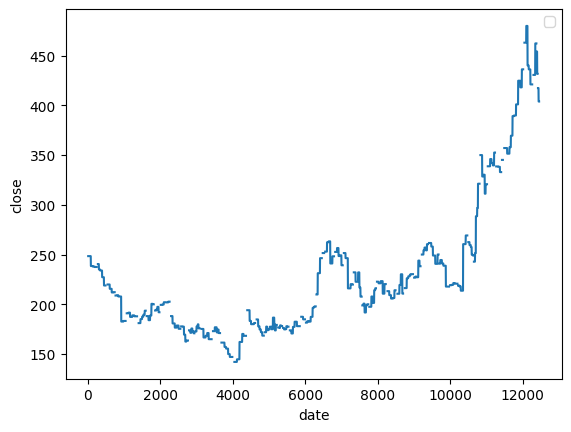

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(merged_train['close'])
plt.xlabel('date')
plt.ylabel('close')
plt.legend()
plt.show()

<ipython-input-13-8c9d8dfac426>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


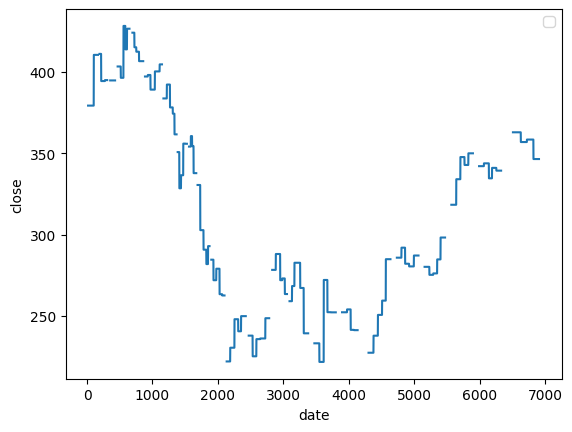

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(merged_test['close'])
plt.xlabel('date')
plt.ylabel('close')
plt.legend()
plt.show()

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 데이터프레임: df (이미 날짜 포함)
# 컬럼: 'date', 'sentiment', 'confidence'


In [15]:
train_df = merged_train
test_df = merged_test

train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

In [16]:
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
train_df['sentiment_score'] = train_df['sentiment'].map(sentiment_map)
test_df['sentiment_score'] = test_df['sentiment'].map(sentiment_map)

In [17]:
weights = np.linspace(1.0, 0.1, 7)  # 1.0 → 0.1까지 7단계로 줄어듦

In [18]:
train_df['sentiment_influence'] = 0.0
test_df['sentiment_influence'] = 0.0

In [19]:
def sums_sentiment_score_for_7_days(df):
  for date, row in tqdm(df.iterrows(), total=len(df)):
      # neutral 또는 NaN은 건너뜀
      if pd.isna(row['sentiment_score']) or pd.isna(row['confidence']):
          continue

      base = row['sentiment_score'] * row['confidence']

      # 7일 동안 가중치 적용해서 누적
      for i in range(7):
          apply_date = date + pd.Timedelta(days=i)
          if apply_date in df.index:
              df.at[apply_date, 'sentiment_influence'] += base * weights[i]

sums_sentiment_score_for_7_days(train_df)
sums_sentiment_score_for_7_days(test_df)

100%|██████████| 7141/7141 [00:34<00:00, 206.87it/s]


In [20]:
train_df[['sentiment', 'confidence', 'sentiment_score', 'sentiment_influence']].head(15)
test_df[['sentiment', 'confidence', 'sentiment_score', 'sentiment_influence']].head(15)

,sentiment,confidence,sentiment_score,sentiment_influence
date,,,,
2025-01-01,neutral,0.9032,0,-2.9182
2025-01-01,negative,0.7729,-1,-2.9182
2025-01-01,neutral,0.8567,0,-2.9182
2025-01-01,negative,0.8651,-1,-2.9182
2025-01-01,positive,0.9340,1,-2.9182
2025-01-01,neutral,0.8688,0,-2.9182
2025-01-01,neutral,0.8944,0,-2.9182
2025-01-01,neutral,0.8764,0,-2.9182
2025-01-01,neutral,0.6386,0,-2.9182


In [21]:
features = ['sentiment_influence', 'open', 'high', 'low', 'adjClose', 'volume']
target   = 'close'
train_data = train_df[ features + [target] ].dropna()
test_data = test_df[ features + [target] ].dropna()

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

In [46]:
import numpy as np

def create_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len, :-1])   # 모든 피처
        y.append(arr[i+seq_len, -1])      # Close만
    return np.array(X), np.array(y)

SEQ_LEN = 10
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

In [43]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, shuffle=False
# )


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

model = Sequential([
    LSTM(units=64, input_shape=(SEQ_LEN, X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20


In [ ]:
# X_val: (샘플수, seq_len, 피처수)
# y_val: (샘플수,)
y_pred = model.predict(X_test)  # 예측값 (스케일된 종가)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_test, label="real Close")
plt.plot(y_pred, label="predicted Close")
plt.title("Actual vs Predicted Close (Scaled)")
plt.legend()
plt.show()


In [ ]:
start = 2000
end = 2200

plt.figure(figsize=(10, 4))
plt.plot(y_test[start:end], label="real Close")
plt.plot(y_pred[start:end], label="predicted Close")
plt.title(f"Zoomed In: Index {start} ~ {end}")
plt.legend()
plt.show()
